# Recurrent Neural Networks Tutorial, Part 2 – Implementing a Language Model RNN with Python, Numpy and Theano

0.0002915451895043732


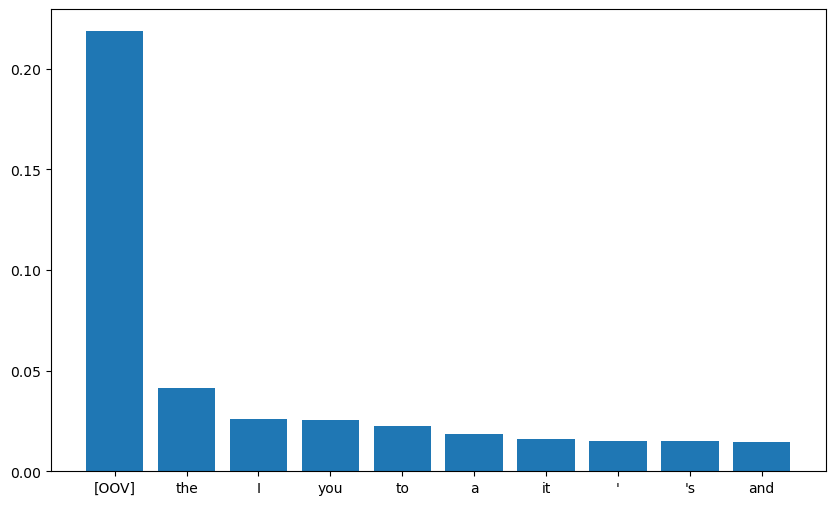

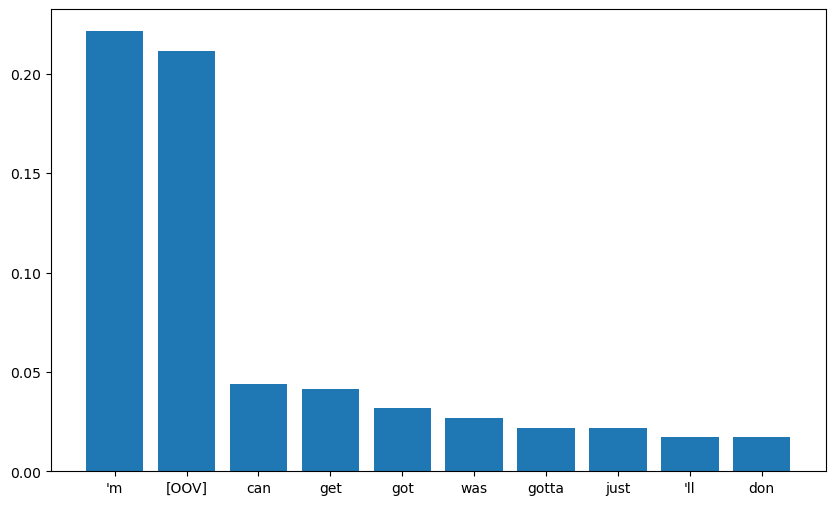

In [6]:
import csv
import itertools
import operator
import numpy as np
import nltk
import sys
from datetime import datetime
sys.path.append("..")
from statnlpbook.utils import *
import statnlpbook.util as util
util.execute_notebook('language_models.ipynb')

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Download NLTK model data (you need to do this once)
nltk.download("book")

[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\xnz224\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\abc.zip.
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\xnz224\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\brown.zip.
[nltk_data]    | Downloading package chat80 to
[nltk_data]    |     C:\Users\xnz224\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\chat80.zip.
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\xnz224\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\cmudict.zip.
[nltk_data]    | Downloading package conll2000 to
[nltk_data]    |     C:\Users\xnz224\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\conll2000.zip.
[nltk_data]    | Downloading package conll2002 to
[nltk_data]    |     C:\Users\xnz224\AppData\Roaming\nltk_data...
[nltk_data]   

True

#### This the second part of the Recurrent Neural Network Tutorial. [The first part is here](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/).

In this part we will implement a full Recurrent Neural Network from scratch using Python and optimize our implementation using [Theano](http://deeplearning.net/software/theano/), a library to perform operations on a GPU. **[The full code is available on Github](https://github.com/dennybritz/rnn-tutorial-rnnlm/)**. I will skip over some boilerplate code that is not essential to understanding Recurrent Neural Networks, but all of that is also [on Github](https://github.com/dennybritz/rnn-tutorial-rnnlm).

### Language Modeling

Our goal is to build a [Language Model](https://en.wikipedia.org/wiki/Language_model) using a Recurrent Neural Network. Here's what that means. Let's say we have sentence  of $m$ words. Language Model allows us to predict the probability of observing the sentence (in a given dataset) as:

$
\begin{aligned}
P(w_1,...,w_m) = \prod_{i=1}^{m}P(w_i \mid w_1,..., w_{i-1}) 
\end{aligned}
$

In words, the probability of a sentence is the product of probabilities of each word given the words that came before it. So, the probability of the sentence "He went to buy some chocolate" would be the probability of "chocolate" given "He went to buy some", multiplied by the probability of "some" given "He went to buy", and so on. 

Why is that useful? Why would we want to assign a probability to observing a sentence?

First, such a model can be used as a scoring mechanism. For example, a Machine Translation system typically generates multiple candidates for an input sentence. You could use a language model to pick the most probable sentence. Intuitively, the most probable sentence is likely to be grammatically correct. Similar scoring happens in speech recognition systems.

But solving the Language Modeling problem also has a cool side effect. Because we can predict the probability of a word given the preceding words, we are able to generate new text. It's a *generative model*. Given an existing sequence of words we sample a next word from the predicted probabilities, and repeat the process until we have a full sentence. Andrew Karparthy [has a great post](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) that demonstrates what language models are capable of. His models are trained on single characters as opposed to full words, and can generate anything from Shakespeare to Linux Code.

Note that in the above equation the probability of each word is conditioned on **all** previous words. In practice, many models have a hard time representing such long-term dependencies due to computational or memory constraints. They are typically limited to looking at only a few of the previous words. RNNs can, in theory, capture such long-term dependencies, but in practice it's a bit more complex. We'll explore that in a later post.

### Training Data and Preprocessing

To train our language model we need text to learn from. Fortunately we don't need any labels to train a language model, just raw text. I downloaded 15,000 longish reddit comments from a [dataset available on Google's BigQuery](https://bigquery.cloud.google.com/table/fh-bigquery:reddit_comments.2015_08). Text generated by our model will sound like reddit commenters (hopefully)! But as with most Machine Learning projects we first need to do some pre-processing to get our data into the right format.

#### 1. Tokenize Text

We have raw text, but we want to make predictions on a per-word basis. This means we must *tokenize* our comments into sentences, and sentences into words. We could just split each of the comments by spaces, but that wouldn't handle punctuation properly. The sentence "He left!" should be 3 tokens: "He", "left", "!". We'll use [NLTK's](http://www.nltk.org/) `word_tokenize` and `sent_tokenize` methods, which do most of the hard work for us.

#### 2. Remove infrequent words

Most words in our text will only appear one or two times. It's a good idea to remove these infrequent words. Having a huge vocabulary will make our model slow to train (we'll talk about why that is later), and because we don't have a lot of contextual examples for such words we wouldn't be able to learn how to use them correctly anyway. That's quite similar to how humans learn. To really understand how to appropriately use a word you need to have seen it in different contexts.

In our code we limit our vocabulary to the `vocabulary_size` most common words (which I set to 8000, but feel free to change it). We replace all words not included in our vocabulary by `UNKNOWN_TOKEN`. For example, if we don't include the word "nonlinearities" in our vocabulary, the sentence "nonlineraties are important in neural networks" becomes "UNKNOWN_TOKEN are important in Neural Networks". The word `UNKNOWN_TOKEN` will become part of our vocabulary and we will predict it just like any other word. When we generate new text we can replace `UNKNOWN_TOKEN` again, for example by taking a randomly sampled word not in our vocabulary, or we could just generate sentences until we get one that doesn't contain an unknown token.

#### 3. Prepend special start and end tokens

We also want to learn which words tend start and end a sentence. To do this we prepend a special `SENTENCE_START` token, and append a special `SENTENCE_END` token to each sentence. This allows us to ask: Given that the first token is `SENTENCE_START`, what is the likely next word (the actual first word of the sentence)?


#### 4. Build training data matrices

The input to our Recurrent Neural Networks are vectors, not strings. So we create a mapping between words and indices, `index_to_word`, and `word_to_index`. For example,  the word "friendly" may be at index 2001. A training example $x$ may look like `[0, 179, 341, 416]`, where 0 corresponds to `SENTENCE_START`. The corresponding label $y$ would be `[179, 341, 416, 1]`. Remember that our goal is to predict the next word, so y is just the x vector shifted by one position with the last element being the `SENTENCE_END` token. In other words, the correct prediction for word `179` above would be `341`, the actual next word.

In [9]:
vocabulary_size = 8000
unknown_token = "UNKNOWN_TOKEN"
sentence_start_token = "SENTENCE_START"
sentence_end_token = "SENTENCE_END"

sentences = itertools.chain(*[nltk.sent_tokenize(x) for x in trainDocs])
# Append SENTENCE_START and SENTENCE_END
sentences = ["%s %s %s" % (sentence_start_token, x, sentence_end_token) for x in sentences]
print("Parsed %d sentences." % (len(sentences)))
    
# Tokenize the sentences into words
tokenized_sentences = [nltk.word_tokenize(sent) for sent in sentences]

# Count the word frequencies
word_freq = nltk.FreqDist(itertools.chain(*tokenized_sentences))
print("Found %d unique words tokens." % len(word_freq.items()))

# Get the most common words and build index_to_word and word_to_index vectors
vocab = word_freq.most_common(vocabulary_size-1)
index_to_word = [x[0] for x in vocab]
index_to_word.append(unknown_token)
word_to_index = dict([(w,i) for i,w in enumerate(index_to_word)])

print("Using vocabulary size %d." % vocabulary_size)
print( "The least frequent word in our vocabulary is '%s' and appeared %d times." % (vocab[-1][0], vocab[-1][1]))

# Replace all words not in our vocabulary with the unknown token
for i, sent in enumerate(tokenized_sentences):
    tokenized_sentences[i] = [w if w in word_to_index else unknown_token for w in sent]

print( "\nExample sentence: '%s'" % sentences[0])
print( "\nExample sentence after Pre-processing: '%s'" % tokenized_sentences[0])

Parsed 212 sentences.
Found 3470 unique words tokens.
Using vocabulary size 8000.
The least frequent word in our vocabulary is 'complaint' and appeared 1 times.

Example sentence: 'SENTENCE_START [BAR]Can't even call this a blues song[/BAR][BAR]It's been so long[/BAR][BAR]Neither one of us was wrong or anything like that[/BAR][BAR]It seems like yesterday[/BAR][BAR][/BAR][BAR][Chorus][/BAR][BAR]In the silence of the city night[/BAR][BAR]When the lonely watch the sky in yearning[/BAR][BAR]I, at rest, lie in peace beside you[/BAR][BAR]I searched a thousand skies before you came[/BAR][BAR][/BAR][BAR][Verse 1][/BAR][BAR]For the 4th 3rd, I Chris Columbus three words from Stevie for the issue[/BAR][BAR]The only thing to call it was official[/BAR][BAR]The way I live for you was as if I die with you[/BAR][BAR]Cause not a moment I spent with you was artifical[/BAR][BAR]The plan from the dome was to build a home with you[/BAR][BAR]Forever had a space in my heart, I roam with you[/BAR][BAR]Hypothe

In [14]:
# Create the training data
X_train = np.asarray([[word_to_index[w] for w in sent[:-1]] for sent in tokenized_sentences], dtype="object")
y_train = np.asarray([[word_to_index[w] for w in sent[1:]] for sent in tokenized_sentences], dtype="object")

Here's an actual training example from our text:

In [15]:
# Print an training data example
x_example, y_example = X_train[17], y_train[17]
print ("x:\n%s\n%s" % (" ".join([index_to_word[x] for x in x_example]), x_example))
print ("\ny:\n%s\n%s" % (" ".join([index_to_word[x] for x in y_example]), y_example))

x:
SENTENCE_START that I 'm kicking while I 'm walking the street [ /BAR ] [ BAR ] I write rhymes just so I can go ( clear throat ) on beat [ /BAR ] [ BAR ] You thinks its so damn luvly do n't you nigga come here [ /BAR ] [ BAR ] You just a frightened little kid all steps and no beard [ /BAR ] [ BAR ] But let me tell you now your talking to a grown ass man [ /BAR ] [ BAR ] I put some shit in your head to fill your stomach to head [ /BAR ] [ BAR ] You do n't believe me well it 's taken me from here to Japan [ /BAR ] [ BAR ] That 's why I 'm laughing to the bank without a getaway van [ /BAR ] [ BAR ] You worrying about your ice and want your shorty to see [ /BAR ] [ BAR ] The only ice that I need is in my L I T [ /BAR ] [ BAR ] I keep my Hennessey straight [ /BAR ] [ BAR ] So skip the fantasy plan [ /BAR ] [ BAR ] That 's why you get up and go [ /BAR ] [ BAR ] That 's shit you got to debate [ /BAR ] [ BAR ] You steady worrying bout your cry-stal [ /BAR ] [ BAR ] Charge your pis-tol [ /BA

#### Building the RNN

For a general overview of RNNs take a look at [first part of the tutorial](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/).

![](http://www.wildml.com/wp-content/uploads/2015/09/rnn.jpg)

Let's get concrete and see what the RNN for our language model looks like. The input $x$ will be a sequence of words (just like the example printed above) and each $x_t$ is a single word. But there's one more thing: Because of how matrix multiplication works we can't simply use a word index (like 36) as an input. Instead, we represent each word as a *one-hot vector* of size `vocabulary_size`. For example, the word with index 36 would be the vector of all 0's and a 1 at position 36. So, each $x_t$ will become a vector, and $x$ will be a matrix, with each row representing a word. We'll perform this transformation in our Neural Network code instead of doing it in the pre-processing. The output of our network $o$ has a similar format. Each $o_t$ is a vector of `vocabulary_size` elements, and each element represents the probability of that word being the next word in the sentence.

Let's recap the equations for the RNN from the first part of the tutorial:

$
\begin{aligned}
s_t &= \tanh(Ux_t + Ws_{t-1}) \\
o_t &= \mathrm{softmax}(Vs_t)
\end{aligned}
$

I always find it useful to write down the dimensions of the matrices and vectors. Let's assume we pick a vocabulary size $C = 8000$ and a hidden layer size $H = 100$. You can think of the hidden layer size as the "memory" of our network. Making it bigger allows us to learn more complex patterns, but also results in additional computation. Then we have:

$
\begin{aligned}
x_t & \in \mathbb{R}^{8000} \\
o_t & \in \mathbb{R}^{8000} \\
s_t & \in \mathbb{R}^{100} \\
U & \in \mathbb{R}^{100 \times 8000} \\
V & \in \mathbb{R}^{8000 \times 100} \\
W & \in \mathbb{R}^{100 \times 100} \\
\end{aligned}
$

This is valuable information. Remember that $U,V$ and $W$ are the parameters of our network we want to learn from data. Thus, we need to learn a total of $2HC + H^2$ parameters. In the case of $C=8000$ and $H=100$ that's 1,610,000.  The dimensions also tell us the bottleneck of our model. Note that because $x_t$ is a one-hot vector, multiplying it with $U$ is essentially the same as selecting a column of U, so we don't need to perform the full multiplication. Then, the biggest matrix multiplication in our network is $Vs_t$. That's why we want to keep our vocabulary size small if possible.

Armed with this, it's time to start our implementation.

#### Initialization

We start by declaring a RNN class an initializing our parameters. I'm calling this class `RNNNumpy` because we will implement a Theano version later. Initializing the parameters $U,V$ and $W$ is a bit tricky. We can't just initialize them to 0's because that would result in symmetric calculations in all our layers. We must initialize them randomly. Because proper initialization seems to have an impact on training results there has been lot of research in this area. It turns out that the best initialization depends on the activation function ($\tanh$ in our case) and one [recommended](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf) approach is to initialize the weights randomly in the interval from $\left[-\frac{1}{\sqrt{n}}, \frac{1}{\sqrt{n}}\right]$ where $n$ is the number of incoming connections from the previous layer. This may sound overly complicated, but don't worry too much about it. As long as you initialize your parameters to small random values it typically works out fine.

In [16]:
class RNNNumpy:
    
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=4):
        # Assign instance variables
        self.word_dim = word_dim
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize the network parameters
        self.U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (hidden_dim, word_dim))
        self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (word_dim, hidden_dim))
        self.W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))
        

Above, `word_dim` is the size of our vocabulary, and `hidden_dim` is the size of our hidden layer (we can pick it). Don't worry about the `bptt_truncate` parameter for now, we'll explain what that is later.

#### Forward Propagation

Next, let's implement the forward propagation (predicting word probabilities) defined by our equations above:

In [17]:
def forward_propagation(self, x):
    # The total number of time steps
    T = len(x)
    # During forward propagation we save all hidden states in s because need them later.
    # We add one additional element for the initial hidden, which we set to 0
    s = np.zeros((T + 1, self.hidden_dim))
    s[-1] = np.zeros(self.hidden_dim)
    # The outputs at each time step. Again, we save them for later.
    o = np.zeros((T, self.word_dim))
    # For each time step...
    for t in np.arange(T):
        # Note that we are indxing U by x[t]. This is the same as multiplying U with a one-hot vector.
        s[t] = np.tanh(self.U[:,x[t]] + self.W.dot(s[t-1]))
        o[t] = softmax(self.V.dot(s[t]))
    return [o, s]

RNNNumpy.forward_propagation = forward_propagation

We not only return the calculated outputs, but also the hidden states. We will use them later to calculate the gradients, and by returning them here we avoid duplicate computation. Each $o_t$ is a vector of probabilities representing the words in our vocabulary, but sometimes, for example when evaluating our model, all we want is the next word with the highest probability. We call this function `predict`:

In [18]:
def predict(self, x):
    # Perform forward propagation and return index of the highest score
    o, s = self.forward_propagation(x)
    return np.argmax(o, axis=1)

RNNNumpy.predict = predict

Let's try our newly implemented methods and see an example output:

In [20]:
np.random.seed(10)
model = RNNNumpy(vocabulary_size)
o, s = model.forward_propagation(X_train[10])
print (o.shape)
print (o)

(36, 8000)
[[0.00012409 0.00012392 0.00012493 ... 0.00012486 0.00012504 0.00012556]
 [0.00012416 0.00012455 0.00012624 ... 0.00012501 0.00012484 0.00012547]
 [0.00012522 0.00012526 0.00012429 ... 0.000125   0.00012517 0.00012522]
 ...
 [0.00012511 0.0001247  0.00012458 ... 0.00012518 0.00012409 0.0001246 ]
 [0.0001249  0.00012534 0.00012596 ... 0.00012552 0.00012533 0.0001246 ]
 [0.00012511 0.00012569 0.00012537 ... 0.00012503 0.00012544 0.000125  ]]


For each word in the sentence (45 above), our model made 8000 predictions representing probabilities of the next word. Note that because we initialized $U,V,W$ to random values these predictions are completely random right now. The following gives the indices of the highest probability predictions for each word:

In [21]:
predictions = model.predict(X_train[10])
print (predictions.shape)
print (predictions)

(36,)
[2133 1284 3106 6510 5763 5027 2563 7316  870 7654  883 2785 5828  923
 4552 6832 5915 6795 3106 6510 2430 5027 2563 7878  824 2794 6737 3107
 7230 2925 6915 7499 4552 4358 3700 6559]


#### Calculating the Loss

To train our network we need a way to measure the errors it makes. We call this the loss function $L$, and our goal is find the parameters $U,V$ and $W$ that minimize the loss function for our training data. A common choice for the loss function is the [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). If we have $N$ training examples (words in our text) and $C$ classes (the size of our vocabulary) then the loss with respect to our predictions $o$ and the true labels $y$ is given by:

$
\begin{aligned}
L(y,o) = - \frac{1}{N} \sum_{n \in N} y_{n} \log o_{n}
\end{aligned}
$

The formula looks a bit complicated, but all it really does is sum over our training examples and add to the loss based on how off our prediction are. The further away $y$ (the correct words) and $o$ (our predictions), the greater the loss will be. We implement the function `calculate_loss`:

In [22]:
def calculate_total_loss(self, x, y):
    L = 0
    # For each sentence...
    for i in np.arange(len(y)):
        o, s = self.forward_propagation(x[i])
        # We only care about our prediction of the "correct" words
        correct_word_predictions = o[np.arange(len(y[i])), y[i]]
        # Add to the loss based on how off we were
        L += -1 * np.sum(np.log(correct_word_predictions))
    return L

def calculate_loss(self, x, y):
    # Divide the total loss by the number of training examples
    N = np.sum((len(y_i) for y_i in y))
    return self.calculate_total_loss(x,y)/N

RNNNumpy.calculate_total_loss = calculate_total_loss
RNNNumpy.calculate_loss = calculate_loss

Let's take a step back and think about what the loss should be for random predictions. That will give us a baseline and make sure our implementation is correct. We have $C$ words in our vocabulary, so each word should be (on average) predicted with probability $1/C$, which would yield a loss of $L = -\frac{1}{N} N \log\frac{1}{C} = \log C$:

In [23]:
# Limit to 1000 examples to save time
print ("Expected Loss for random predictions: %f" % np.log(vocabulary_size))
print ("Actual loss: %f" % model.calculate_loss(X_train[:1000], y_train[:1000]))

Expected Loss for random predictions: 8.987197


C:\Users\xnz224\AppData\Local\Temp\ipykernel_9456\1460852643.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  N = np.sum((len(y_i) for y_i in y))


Actual loss: 8.987441


Pretty close! Keep in mind that evaluating the loss on the full dataset is an expensive operation and can take hours if you have a lot of data!

#### Training the RNN with SGD and Backpropagation Through Time (BPTT)

Remember that we want to find the parameters $U,V$ and $W$ that minimize the total loss on the training data. The most common way to do this is SGD, Stochastic Gradient Descent. The idea behind SGD is pretty simple. We iterate over all our training examples and during each iteration we nudge the parameters into a direction that reduces the error. These directions are given by the gradients on the loss: $\frac{\partial L}{\partial U}, \frac{\partial L}{\partial V}, \frac{\partial L}{\partial W}$. SGD also needs a *learning rate*, which defines how big of a step we want to make in each iteration. SGD is the most popular optimization method not only for Neural Networks, but also for many other Machine Learning algorithms. As such there has been a lot of research on how to optimize SGD using batching, parallelism and adaptive learning rates. Even though the basic idea is simple, implementing SGD in a really efficient way can become very complex. If you want to learn more about SGD [this](http://cs231n.github.io/optimization-1/) is a good place to start. Due to its popularity there are a wealth of tutorials floating around the web, and I don't want to duplicate them here. I'll implement a simple version of SGD that should be understandable even without a background in optimization.

But how do we calculate those gradients we mentioned above? In a [traditional Neural Network](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/) we do this through the backpropagation algorithm. In RNNs we use a slightly modified version of the this algorithm called Backpropagation Through Time (BPTT). Because the parameters are shared by all time steps in the network, the gradient at each output depends not only on the calculations of the current time step, but also the previous time steps. If you know calculus, it really is just applying the chain rule. The next part of the tutorial will be all about BPTT, so I won't go into detailed derivation here. For a general introduction to backpropagation check out [this](http://colah.github.io/posts/2015-08-Backprop/) and this [post](http://cs231n.github.io/optimization-2/). For now you can treat BPTT as a black box. It takes as input a training example $(x,y)$ and returns the gradients $\frac{\partial L}{\partial U}, \frac{\partial L}{\partial V}, \frac{\partial L}{\partial W}$.

In [24]:
def bptt(self, x, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(x)
    # We accumulate the gradients in these variables
    dLdU = np.zeros(self.U.shape)
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    delta_o = o
    delta_o[np.arange(len(y)), y] -= 1.
    # For each output backwards...
    for t in np.arange(T)[::-1]:
        dLdV += np.outer(delta_o[t], s[t].T)
        # Initial delta calculation
        delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
        # Backpropagation through time (for at most self.bptt_truncate steps)
        for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
            # print "Backpropagation step t=%d bptt step=%d " % (t, bptt_step)
            dLdW += np.outer(delta_t, s[bptt_step-1])              
            dLdU[:,x[bptt_step]] += delta_t
            # Update delta for next step
            delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
    return [dLdU, dLdV, dLdW]

RNNNumpy.bptt = bptt

#### Gradient Checking

Whenever you implement backpropagation it is good idea to also implement *gradient checking*, which is a way of verifying that your implementation is correct. The idea behind gradient checking is that derivative of a parameter is equal to the slope at the point, which we can approximate by slightly changing the parameter and then dividing by the change:

$
\begin{aligned}
\frac{\partial L}{\partial \theta} \approx \lim_{h \to 0} \frac{J(\theta + h) - J(\theta -h)}{2h}
\end{aligned}
$

We then compare the gradient we calculated using backpropagation to the gradient we estimated with the method above. If there's no large difference we are good. The approximation needs to calculate the total loss for *every* parameter, so that gradient checking is very expensive (remember, we had more than a million parameters in the example above). So it's a good idea to perform it on a model with a smaller vocabulary.

In [26]:
def gradient_check(self, x, y, h=0.001, error_threshold=0.01):
    # Calculate the gradients using backpropagation. We want to checker if these are correct.
    bptt_gradients = model.bptt(x, y)
    # List of all parameters we want to check.
    model_parameters = ['U', 'V', 'W']
    # Gradient check for each parameter
    for pidx, pname in enumerate(model_parameters):
        # Get the actual parameter value from the mode, e.g. model.W
        parameter = operator.attrgetter(pname)(self)
        print ("Performing gradient check for parameter %s with size %d." % (pname, np.prod(parameter.shape)))
        # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
        it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            ix = it.multi_index
            # Save the original value so we can reset it later
            original_value = parameter[ix]
            # Estimate the gradient using (f(x+h) - f(x-h))/(2*h)
            parameter[ix] = original_value + h
            gradplus = model.calculate_total_loss([x],[y])
            parameter[ix] = original_value - h
            gradminus = model.calculate_total_loss([x],[y])
            estimated_gradient = (gradplus - gradminus)/(2*h)
            # Reset parameter to original value
            parameter[ix] = original_value
            # The gradient for this parameter calculated using backpropagation
            backprop_gradient = bptt_gradients[pidx][ix]
            # calculate The relative error: (|x - y|/(|x| + |y|))
            relative_error = np.abs(backprop_gradient - estimated_gradient)/(np.abs(backprop_gradient) + np.abs(estimated_gradient))
            # If the error is to large fail the gradient check
            if relative_error > error_threshold:
                print ("Gradient Check ERROR: parameter=%s ix=%s" % (pname, ix))
                print ("+h Loss: %f" % gradplus)
                print ("-h Loss: %f" % gradminus)
                print ("Estimated_gradient: %f" % estimated_gradient)
                print ("Backpropagation gradient: %f" % backprop_gradient)
                print ("Relative Error: %f" % relative_error)
                return 
            it.iternext()
        print ("Gradient check for parameter %s passed." % (pname))

RNNNumpy.gradient_check = gradient_check

# To avoid performing millions of expensive calculations we use a smaller vocabulary size for checking.
grad_check_vocab_size = 100
np.random.seed(10)
model = RNNNumpy(grad_check_vocab_size, 10, bptt_truncate=1000)
model.gradient_check([0,1,2,3], [1,2,3,4])

Performing gradient check for parameter U with size 1000.
Gradient check for parameter U passed.
Performing gradient check for parameter V with size 1000.


C:\Users\xnz224\AppData\Local\Temp\ipykernel_9456\1865409233.py:28: RuntimeWarning: invalid value encountered in scalar divide
  relative_error = np.abs(backprop_gradient - estimated_gradient)/(np.abs(backprop_gradient) + np.abs(estimated_gradient))


Gradient check for parameter V passed.
Performing gradient check for parameter W with size 100.
Gradient check for parameter W passed.


#### SGD Implementation

Now that we are able to calculate the gradients for our parameters we can implement SGD. I like to do this in two steps: 1. A function `sdg_step` that calculates the gradients and performs the updates for one batch. 2. An outer loop that iterates through the training set and adjusts the learning rate.

In [27]:
# Performs one step of SGD.
def numpy_sdg_step(self, x, y, learning_rate):
    # Calculate the gradients
    dLdU, dLdV, dLdW = self.bptt(x, y)
    # Change parameters according to gradients and learning rate
    self.U -= learning_rate * dLdU
    self.V -= learning_rate * dLdV
    self.W -= learning_rate * dLdW

RNNNumpy.sgd_step = numpy_sdg_step

In [29]:
# Outer SGD Loop
# - model: The RNN model instance
# - X_train: The training data set
# - y_train: The training data labels
# - learning_rate: Initial learning rate for SGD
# - nepoch: Number of times to iterate through the complete dataset
# - evaluate_loss_after: Evaluate the loss after this many epochs
def train_with_sgd(model, X_train, y_train, learning_rate=0.005, nepoch=100, evaluate_loss_after=5):
    # We keep track of the losses so we can plot them later
    losses = []
    num_examples_seen = 0
    for epoch in range(nepoch):
        # Optionally evaluate the loss
        if (epoch % evaluate_loss_after == 0):
            loss = model.calculate_loss(X_train, y_train)
            losses.append((num_examples_seen, loss))
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print ("%s: Loss after num_examples_seen=%d epoch=%d: %f" % (time, num_examples_seen, epoch, loss))
            # Adjust the learning rate if loss increases
            if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                learning_rate = learning_rate * 0.5  
                print ("Setting learning rate to %f" % learning_rate)
            sys.stdout.flush()
        # For each training example...
        for i in range(len(y_train)):
            # One SGD step
            model.sgd_step(X_train[i], y_train[i], learning_rate)
            num_examples_seen += 1

Done! Let's try to get a sense of how long it would take to train our network:

In [30]:
np.random.seed(10)
model = RNNNumpy(vocabulary_size)
%timeit model.sgd_step(X_train[10], y_train[10], 0.005)

109 ms ± 2.56 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Uh-oh, bad news. One step of SGD takes approximately 350 milliseconds on my laptop. We have about 80,000 examples in our training data, so one epoch (iteration over the whole data set) would take several hours. Multiple epochs would take days, or even weeks! And we're still working with a small dataset compared to what's being used by many of the companies and researchers out there. What now?

Fortunately there are many ways to speed up our code. We could stick with the same model and make our code run faster, or we could modify our model to be less computationally expensive, or both. Researchers have identified many ways to make models less computationally expensive, for example by using a hierarchical softmax or adding projection layers to avoid the large matrix multiplications (see also [here](http://arxiv.org/pdf/1301.3781.pdf) or [here](http://www.fit.vutbr.cz/research/groups/speech/publi/2011/mikolov_icassp2011_5528.pdf)). But I want to keep our model simple and go the first route: Make our implementation run faster using a GPU. Before doing that though, let's just try to run SGD with a small dataset and check if the loss actually decreases:

In [31]:
np.random.seed(10)
# Train on a small subset of the data to see what happens
model = RNNNumpy(vocabulary_size)
losses = train_with_sgd(model, X_train[:100], y_train[:100], nepoch=10, evaluate_loss_after=1)

C:\Users\xnz224\AppData\Local\Temp\ipykernel_9456\1460852643.py:14: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  N = np.sum((len(y_i) for y_i in y))


2024-09-12 15:10:43: Loss after num_examples_seen=0 epoch=0: 8.987421
2024-09-12 15:11:20: Loss after num_examples_seen=100 epoch=1: 9.905413
Setting learning rate to 0.002500
2024-09-12 15:11:55: Loss after num_examples_seen=200 epoch=2: 9.425783
2024-09-12 15:12:33: Loss after num_examples_seen=300 epoch=3: 31.447634
Setting learning rate to 0.001250
2024-09-12 15:13:08: Loss after num_examples_seen=400 epoch=4: 7.553345
2024-09-12 15:13:45: Loss after num_examples_seen=500 epoch=5: 12.306053
Setting learning rate to 0.000625
2024-09-12 15:14:22: Loss after num_examples_seen=600 epoch=6: 5.435099
2024-09-12 15:14:59: Loss after num_examples_seen=700 epoch=7: 5.200840
2024-09-12 15:15:36: Loss after num_examples_seen=800 epoch=8: 4.745959
2024-09-12 15:16:13: Loss after num_examples_seen=900 epoch=9: 5.663882
Setting learning rate to 0.000313


Good, it seems like our implementation is at least doing something useful and decreasing the loss, just like we wanted.

### Generating Text

Now that we have our model we can ask it to generate new text for us! Let's implement a helper function to generate new sentences:

In [52]:
def generate_sentence(model):
    # We start the sentence with the start token
    new_sentence = [word_to_index[sentence_start_token]]
    # Repeat until we get an end token
    while not new_sentence[-1] == word_to_index[sentence_end_token]:
        next_word_probs = model.forward_propagation(new_sentence)
        sampled_word = word_to_index[unknown_token]
        # We don't want to sample unknown words
        while sampled_word == word_to_index[unknown_token]:
            samples = np.random.multinomial(1, softmax(next_word_probs[-1][0]))
            sampled_word = np.argmax(samples)
        new_sentence.append(sampled_word)
    sentence_str = [index_to_word[x] for x in new_sentence[1:-1]]
    return sentence_str

num_sentences = 10
senten_min_length = 7

for i in range(num_sentences):
    sent = []
    # We want long sentences, not sentences with one or two words
    while len(sent) < senten_min_length:
        sent = generate_sentence(model)
    print (" ".join(sent))

'' as ) mind na that It the `` is ? if '' a ca even You how ) by But it as [ Chorus SENTENCE_START that can never when what J-Live ... n't man it do that back /BAR ! 'm but can '' So So as Chorus Cause they so I { was from ca BAR see so when * mind n't na with ... say your up it ] Chorus ! ! got now so 're stroke you when 'm - * SENTENCE_START ? , see with I BAR with ' 're /BAR they and like my shit shit To SENTENCE_START at they that know do a life say stroke na how even BAR at ! /BAR as shit It when with by man even And just na for [ but You , when - see when To no Cause n't Cause * That a ' ca ( make { [ 're when Chorus ) ] SENTENCE_START To know with when now ? through BAR how they my - do mind up your to out , Anna Cause `` to got ' I mind but one and stroke when out my know for one Chorus 'm what with [ now BAR - as even of `` so ] It or J-Live me time ( say now - ca back got they through { my up can back just even the out ) one as '' the for 's So for just To SENTENCE_START I ! 

A few selected (censored) sentences. I added capitalization.

- Anyway, to the city scene you're an idiot teenager.
- What ? ! ! ! ! ignore!
- Screw fitness, you're saying: https
- Thanks for the advice to keep my thoughts around girls.
- Yep, please disappear with the terrible generation.

Looking at the generated sentences there are a few interesting things to note. The model successfully learn syntax. It properly places commas (usually before and's and or's) and ends sentence with punctuation. Sometimes it mimics internet speech such as multiple exclamation marks or smileys.

However, the vast majority of generated sentences don't make sense or have grammatical errors. One reason could be that we did not train our network long enough (or didn't use enough training data). That may be true, but it's most likely not the main reason. **Our vanilla RNN  can't generate meaningful text because it's unable to learn dependencies between words that are several steps apart**. That's also why RNNs failed to gain popularity when they were first invented. They were beautiful in theory but didn't work well in practice, and we didn't immediately understand why.

Fortunately, the difficulties in training RNNs are [much better understood](http://arxiv.org/abs/1211.5063) now. In the next part of this tutorial we will explore the Backpropagation Through Time (BPTT) algorithm in more detail and demonstrate what's called the *vanishing gradient problem*. This will motivate our move to more sophisticated RNN models, such as LSTMs, which are the current state of the art for many tasks in NLP (and can generate much better reddit comments!).  Everything you learned in this tutorial also applies to LSTMs and other RNN models, so don't feel discouraged if the results for a vanilla RNN are worse then you expected.


In [53]:
perplexity(model, test)

AttributeError: 'RNNNumpy' object has no attribute 'order'